<center><h1>AI in Web Development</h1></center>

---

<center><h2>Lesson 04</h2></center>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/snsie/ai-webdev/blob/main/lessons/lesson-04/lesson-04.ipynb)

This notebook is based on [this example](https://colab.research.google.com/github/ehennis/ReinforcementLearning/blob/master/05-DQN.ipynb#scrollTo=DPWjJiOZ2uVd) and [this example](https://colab.research.google.com/github/MrSyee/pg-is-all-you-need/blob/master/02.PPO.ipynb)



<h1 align="center">Reinforcement Learning (RL)</h1>

<center><img src="https://github.com/snsie/ai-webdev/blob/main/images/what-is-reinforcement-learning.png?raw=true" width='320px'/></center>


###Environment
  * The stage that contains the simulation

<br/>

###Agent
  * The entity making decisions
  * Can be represented as a neural network

<br/>

###States
* Set of observations that agents that can be performed by the agent
* example: agent's position

<br/>

###Actions
* Set of activities that can be performed by the agent
* example: move right, move left

<br/>

###Rewards
* Provides agents feedback about their performance


<center><h1>Cart Pole Example</h1></center>

---

<center><h4>the cart's goal: balance the pole</h4></center>


[Gym Docs](https://www.gymlibrary.ml/environments/classic_control/cart_pole/)

|Bad Cart          |  Good Cart  |
|:-------------------------:|:-------------------------:|
| <img src='https://github.com/snsie/ai-webdev/blob/main/images/cartpole-initial.gif?raw=true' width="300"/>  | <img src='https://github.com/snsie/ai-webdev/blob/main/images/cartpole-trained.gif?raw=true' width="300"/> |

<center><h3><u>Actions</u></h3></center>

| Num | Action                 |
|-----|------------------------|
| 0   | Push cart to the left  |
| 1   | Push cart to the right |

<br/>
<br/>

<center><h3><u>States</u></h3></center>

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|:-------------------|:-----------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

<br/>

[Cart Pole Python File](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

RL Algorithm to be used in this example:

<center><h1>Q-learning</h1></center>

<br/>

<h4>
\begin{align}
Q(s,a) = r(s,a) + \gamma \cdot \max_{a} Q(s',a')
\end{align}
</h4>

<br/>

###$Q(s,a)$ = Q-value

###$r(s,a)$ = reward for current action

###$\gamma$ = parameter that scales: $\max_{a}Q(s',a')$

###$\max_{a}Q(s',a')$ = Maximum Q-value predicted in the next state 

<br/>

In [73]:
#from: https://colab.research.google.com/github/MrSyee/pg-is-all-you-need/blob/master/02.PPO.ipynb#scrollTo=weZ2GZJDIu1u
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.


In [74]:
#Imports
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
from typing import Deque, Dict, List, Tuple
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
import random
from IPython.display import clear_output

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) #Set the seed to keep the environment consistent across runs

[50]

**Experience Replay**  
To perform an experience replay, the algorithm stores all of the agents experiences {$s_t,a_t,r_t,s_{t+1}$} at each time step in a data set. Normally in a q-learner, we would run the update rule on them. But, with experience replay we just store them.  

Later during the training process these replays will be drawn uniformly from the memory queue and be ran through the update rule. There are 2 ways to handle this and I have coded both in the past. The first is to run them on every loop and the other is to run them after X amount of runs. In this code below, I run them each time.

**Deep Q-Network Class**  
The following class is the deep Q-network that is built using the neural network code from Keras.  
**init**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This creates the class and sets the local parameters.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I use a *deque* for the local memory to hold the experiences and a keras model for the NN.  

**build_model(self)**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This builds the NN. I am using sequential model. Each of the layers are *Dense* despite the fact the document talks about using *Convolution*. But, they are only using that because they need to convert pixels and I already have numbers.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I am using an input layer(4), 24 neuron layer, 24 neuron layer, and an output layer(2).  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For calculating the loss I am using mean squared error.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For an optimizer I am using [Adam](https://arxiv.org/abs/1412.6980v8). It is a variant of gradient descent and you can read the technical document at the link. If you want a slightly lighter explaining you can check out [Machine Learning Mastery](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/). You could also use SGD (Stochastic Gradient Descent) but Adam gives me better results and seems to be the standard in most examples.  

**action(self,state):**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This generates the action.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Explore: I am using the epsilon like previous lessons.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Exploit: I use the NN to grab the 2 possible actions and then grab the argmax to find the better one  

**test_action(self,state):**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This generates the action when I am testing. I want to 100% exploit  

**store(self, state, action, reward, nstate, done):**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This places the observables in memory  

**experience_replay(self, batch_size):**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This is where the training occurs. We grab the sample batches and then use the NN to predict the optimal action.

In [75]:
class DeepQNetwork():
    def __init__(self, states, actions, learningRate, gamma, epsilonInit,epsilon_min, epsilon_decay):
        self._numStates = states
        self._numActions = actions
        self.memory = deque([], maxlen=2500)
        self._learningRate = learningRate
        self._gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilonInit
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
    
    # create a function to initialize the neural network
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(64, input_dim=self._numStates, activation='relu')) #[Input] -> Layer 1
        # model.add(keras.layers.Dense(64, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self._numActions, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(learning_rate=self._learningRate)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self._numActions) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory
        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        # print(np_array)
        st = np.zeros((0,self._numStates)) #States
        nst = np.zeros( (0,self._numStates) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        targetArr=[]
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
                # targetArr.append(target)
                # self.targetAve+=target
            else:   #Non terminal
                # target = np.min([1,reward + self._gamma * np.amax(nst_action_predict_model)])
                target = reward + self._gamma * np.amax(nst_action_predict_model)
                # targetArr.append(target)
                # self.targetAve+=target
            # print(targetArr)            
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self._numStates)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay




In [76]:
def plotTotalReward(episodeNum, tot_rewards, epsilon,storedRewards,storedEpsilons):
    def subplot(loc: int, title: str, values: List[float]):
        plt.subplot(loc)
        plt.title(title)
        plt.plot(values)

    subplot_params = [
        (121, f"episode: {episodeNum}, total reward: {tot_rewards}", storedRewards),
        (122, f"episode: {episodeNum}, epsilon: {epsilon}", storedEpsilons),
    ]

    clear_output(True)
    plt.figure(figsize=(30, 5))
    for loc, title, values in subplot_params:
        subplot(loc, title, values)
    plt.show()

In [77]:
#Global Variables
EPISODES = 500
TRAIN_END = 0

In [78]:
#Hyper Parameters

gamma=0.95

learningRate=0.1

batchSize=32

In [79]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learningRate, gamma, 0, 0.001, 0.995 )
batch_size = batchSize

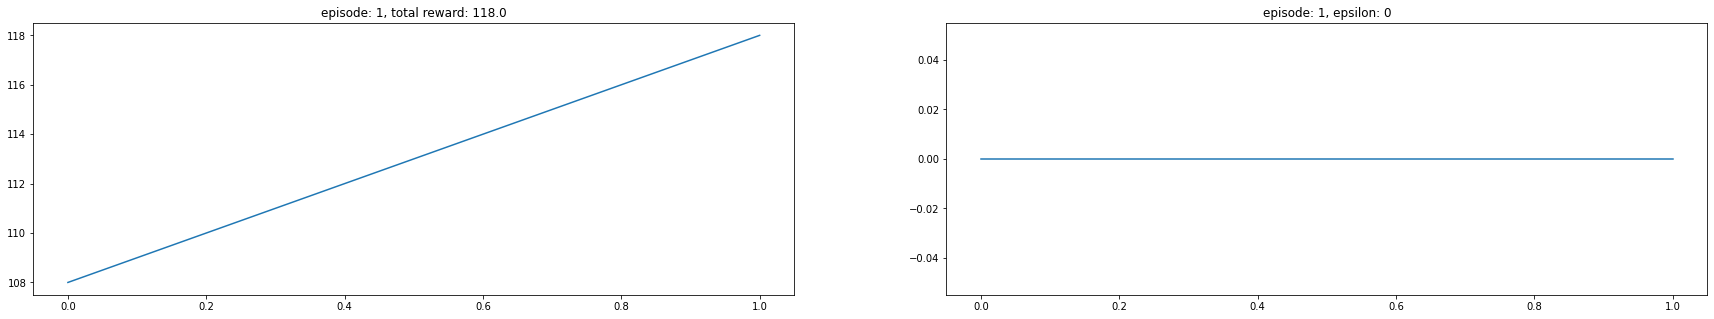

KeyboardInterrupt: ignored

In [83]:
#Training
def trainAgent():
  rewards = [] #Store rewards for graphing
  epsilons = [] # Store the Explore/Exploit
  TEST_Episodes = 0
  for e in range(EPISODES):
      state = envCartPole.reset()
      state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
      tot_rewards = 0
      for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
          action = dqn.action(state)
          nstate, reward, done, _ = envCartPole.step(action)
          nstate = np.reshape(nstate, [1, nS])
          tot_rewards += reward
          dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
          state = nstate
          #done: CartPole fell. 
          #time == 209: CartPole stayed upright
          if done or time == 209:
              rewards.append(tot_rewards)
              epsilons.append(dqn.epsilon)
              plotTotalReward(e, tot_rewards, dqn.epsilon,rewards,epsilons)
              # print("episode: {}/{}, score: {}, e: {}"
              #       .format(e, EPISODES, tot_rewards, dqn.epsilon))
              break
          #Experience Replay
          if len(dqn.memory) > batch_size:
              dqn.experience_replay(batch_size)
      #If our current NN passes we are done
      #I am going to use the last 5 runs
      if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
          #Set the rest of the EPISODES for testing
          TEST_Episodes = EPISODES - e
          TRAIN_END = e
          break

trainAgent()

In [ ]:
#Test the agent that was trained
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

**Results**  
Here is a graph of the results. If everything was done correctly you should see the rewards over the red line.  

Black: This is the 100 episode rolling average  
Red: This is the "solved" line at 195  
Blue: This is the reward for each episode  
Green: This is the value of epsilon scaled by 200  
Yellow: This is where the tests started.

In [ ]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()

In [ ]:
# # test
# if IN_COLAB:
#     agent.env = gym.wrappers.Monitor(agent.env, "videos", force=True)
# frames = agent.test()

In [ ]:
#from: https://colab.research.google.com/github/MrSyee/pg-is-all-you-need/blob/master/02.PPO.ipynb#scrollTo=_9SokMoDIu18
if IN_COLAB:  # for colab
    import base64
    import glob
    import io
    import os

    from IPython.display import HTML, display

    def ipython_show_video(path: str) -> None:
        """Show a video at `path` within IPython Notebook."""
        if not os.path.isfile(path):
            raise NameError("Cannot access: {}".format(path))

        video = io.open(path, "r+b").read()
        encoded = base64.b64encode(video)

        display(HTML(
            data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>
            """.format(encoded.decode("ascii"))
        ))

    list_of_files = glob.glob("videos/*.mp4")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    ipython_show_video(latest_file)

else:  # for jupyter
    from matplotlib import animation
    from JSAnimation.IPython_display import display_animation
    from IPython.display import display


    def display_frames_as_gif(frames):
        """Displays a list of frames as a gif, with controls."""
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames = len(frames), interval=50
        )
        display(display_animation(anim, default_mode='loop'))


    # display 
    display_frames_as_gif(frames)

**Changes**  
*hyper parameters*: You can alter alpha, gamma, batch size, and episode length to see what differences the algorithm returns.  
*Training End*: You can also change the line where I only check the last 5 runs before switching to testing mode (if len(rewards) > 5 and np.average(rewards[-5:]) > 195:) as that doesn't prove it was solved. The reason I did this was because I wanted to limit the amount of runs I made.  

**Conclusion**  
This is a Deep Q-Network implementation. There are some changes you can make here and there but it follows the paper. Hopefully, you were able to understand the code as well as make your own version to compare with this one.

**Reference**  
Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Petersen, S. (2015). *Human-level control through deep reinforcement learning*. Nature, 518(7540), 529